In [1]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from utils import market_values, market_values_by_time_index

In [2]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# counts of number of regions where a generator of e specific carrier is present
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [4]:
carriers = n.generators.carrier.drop_duplicates().tolist()
# carriers = ['offwind-ac','onwind', 'solar','ror','offwind-dc','gas','residential rural solar thermal','services rural solar thermal','residential urban decentral solar thermal','services urban decentral solar thermal','urban central solar thermal','oil','solar rooftop']
carriers = ['offwind-ac','onwind', 'solar','ror','offwind-dc','solar rooftop']
carriers

['offwind-ac', 'onwind', 'solar', 'ror', 'offwind-dc', 'solar rooftop']

In [5]:
mv_carriers = pd.DataFrame(index = n.buses.location.unique(), columns = carriers)

for carrier in carriers:
    mv_carriers[carrier] = market_values(n, carrier)

mv_carriers

,offwind-ac,onwind,solar,ror,offwind-dc,solar rooftop
AL0 0,126.148417,131.075254,44.628736,NaN,NaN,56.499070
AT0 0,NaN,83.457109,54.679083,87.946522,NaN,64.462333
AT0 1,NaN,84.612302,65.745903,97.282183,NaN,77.031453
AT0 2,NaN,90.012931,58.223787,85.291980,NaN,69.284880
BA0 0,NaN,119.715551,51.160537,NaN,NaN,58.363750
...,...,...,...,...,...,...
SE3 6,60.483666,53.277864,58.963028,77.032750,60.000468,68.822199
SE3 7,59.877949,63.297661,60.256194,66.164361,60.578980,63.005445
SI0 0,148.386481,125.246390,60.556211,111.663140,NaN,62.729094
SK0 0,NaN,91.144751,54.957441,93.823663,NaN,61.104808


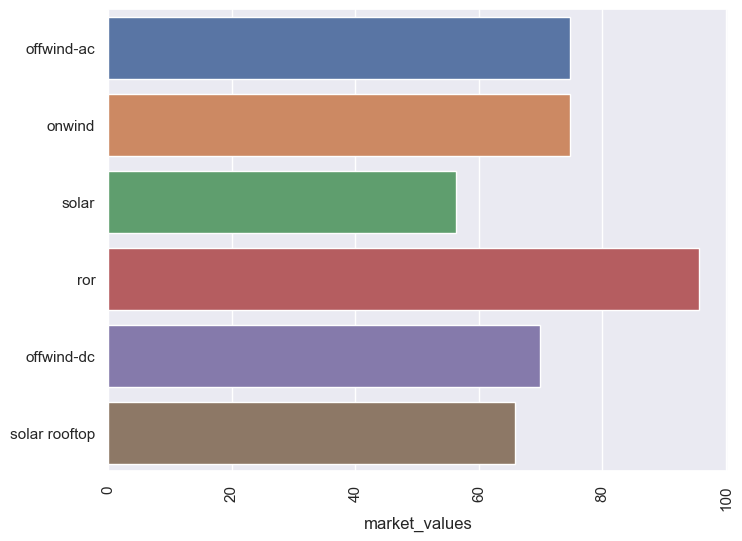

In [6]:
# plot overall market value for all carriers
mv_carriers_mean = pd.DataFrame(mv_carriers.mean())
mv_carriers_mean.columns = ["market_values"]
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=mv_carriers_mean,y=mv_carriers_mean.index, x="market_values", orient="h")
ticks = plt.xticks(rotation=90)

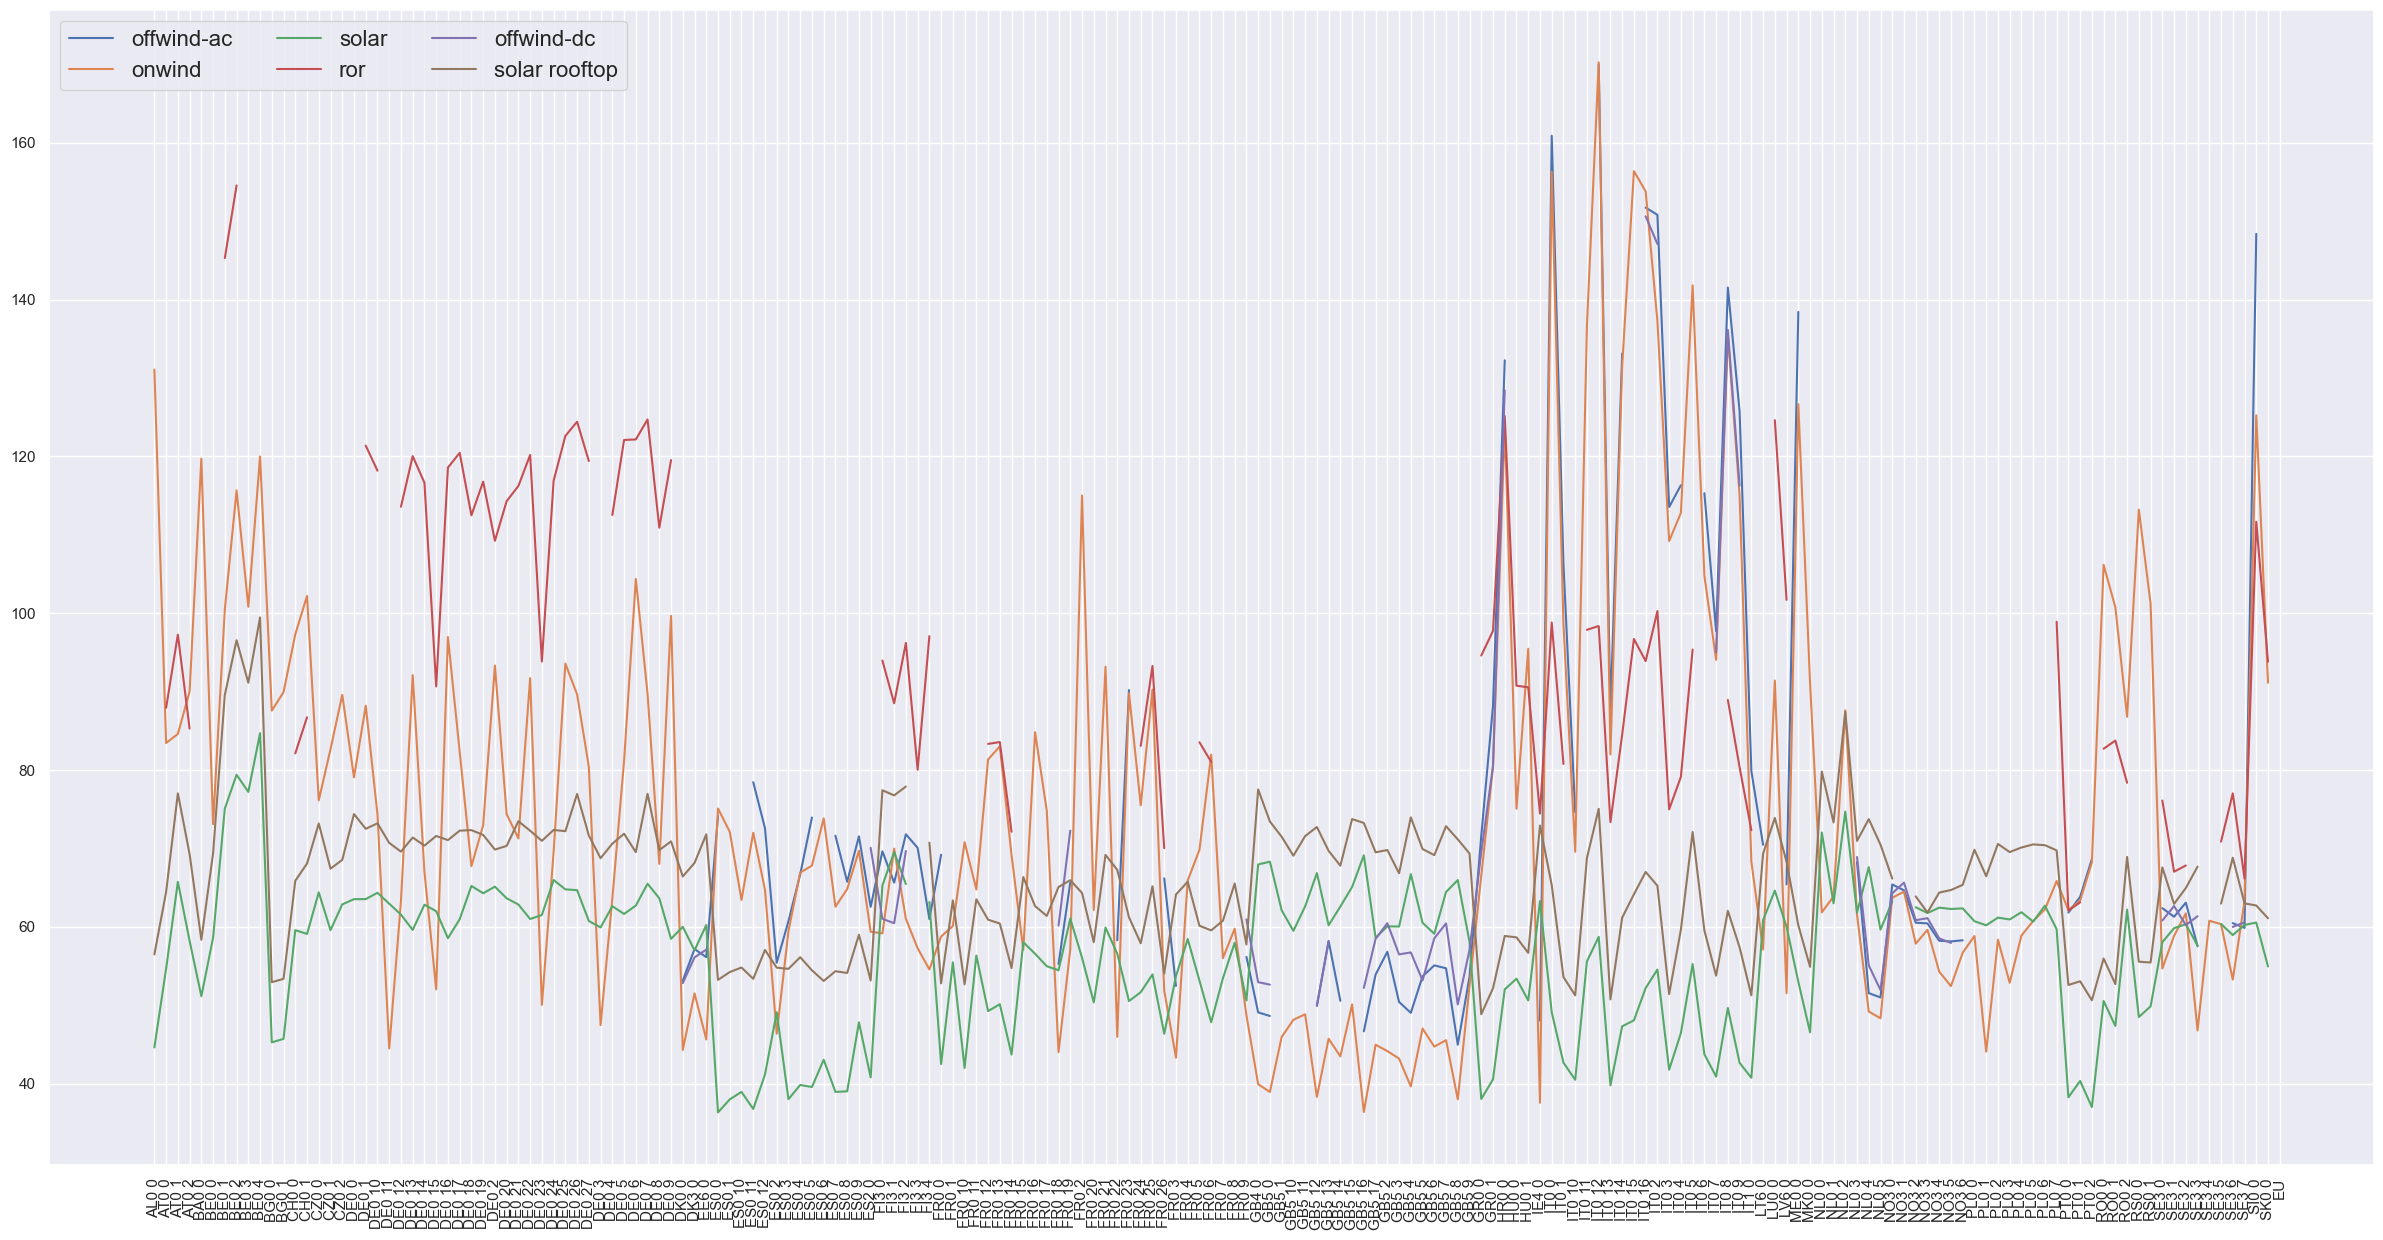

In [7]:
# market value of all carriers for all 181 regions
ax = mv_carriers.plot(figsize=(30,15))
plt.legend(loc='upper left', ncol=3, prop={'size': 16})
ax.set_xticks(range(len(mv_carriers)))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.index.tolist()], rotation=90)

In [8]:
mv_carriers

,offwind-ac,onwind,solar,ror,offwind-dc,solar rooftop
AL0 0,126.148417,131.075254,44.628736,NaN,NaN,56.499070
AT0 0,NaN,83.457109,54.679083,87.946522,NaN,64.462333
AT0 1,NaN,84.612302,65.745903,97.282183,NaN,77.031453
AT0 2,NaN,90.012931,58.223787,85.291980,NaN,69.284880
BA0 0,NaN,119.715551,51.160537,NaN,NaN,58.363750
...,...,...,...,...,...,...
SE3 6,60.483666,53.277864,58.963028,77.032750,60.000468,68.822199
SE3 7,59.877949,63.297661,60.256194,66.164361,60.578980,63.005445
SI0 0,148.386481,125.246390,60.556211,111.663140,NaN,62.729094
SK0 0,NaN,91.144751,54.957441,93.823663,NaN,61.104808


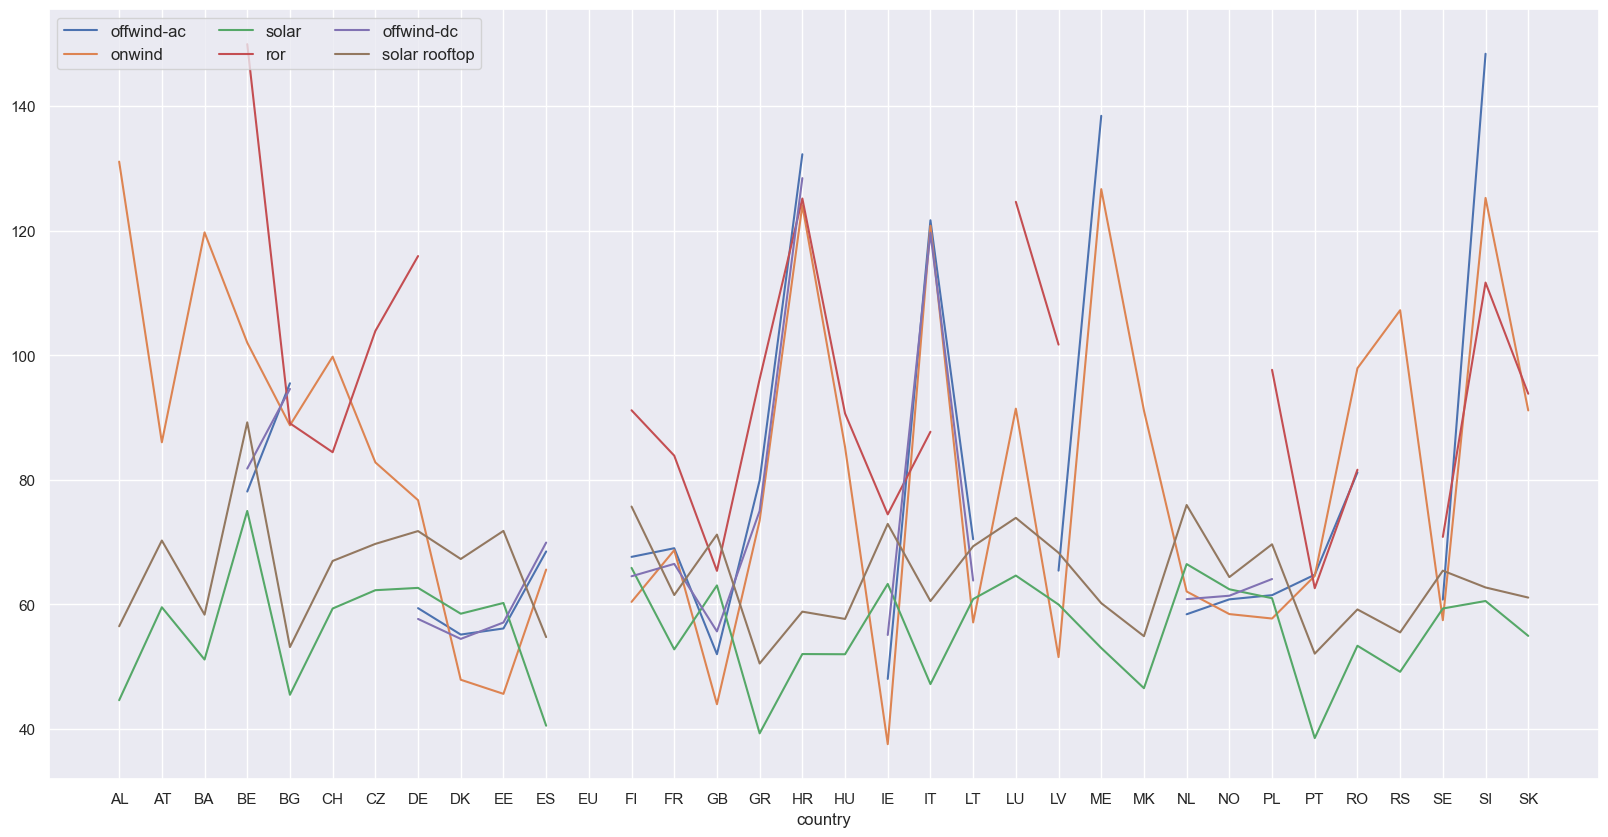

In [9]:
# Plot of mv of carriers by country
mv_carriers["country"] = mv_carriers.index.str[:2]
ax = mv_carriers.groupby(by="country").mean().plot(figsize=(20,10))
plt.legend(loc='upper left', ncol=3, prop={'size': 12})
ax.set_xticks(range(len(mv_carriers.groupby(by="country").mean())))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.groupby(by="country").mean().index.tolist()], rotation=0)

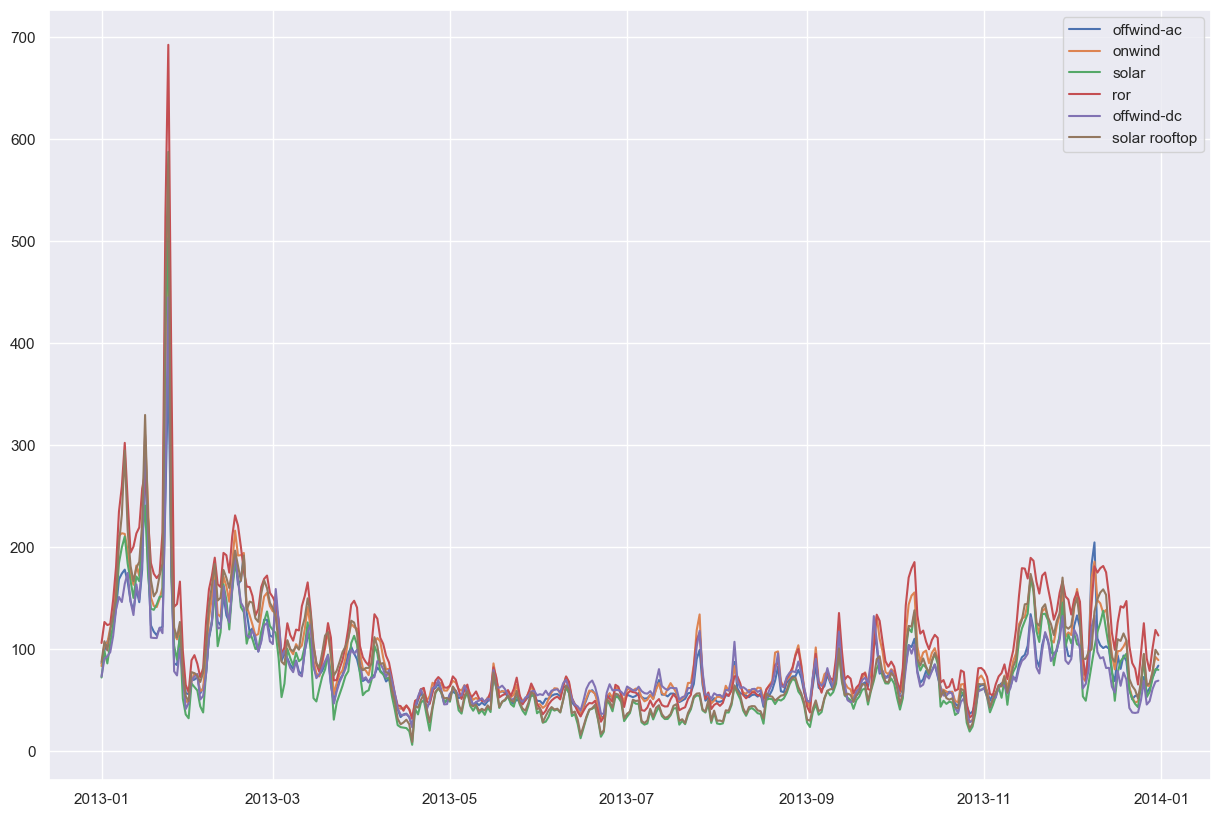

In [10]:
# Plot of market values of carriers for every day
carriers1 = ['offwind-ac','onwind', 'solar','ror','offwind-dc','solar rooftop']

days = pd.DatetimeIndex(np.unique(n.generators_t.p.index.date))
plt.figure(figsize=(15, 10))

for carrier in carriers1:
    mv_daily = market_values_by_time_index(n, days, carrier)
    plt.plot(mv_daily.mean(axis=1), label=carrier)

plt.legend()

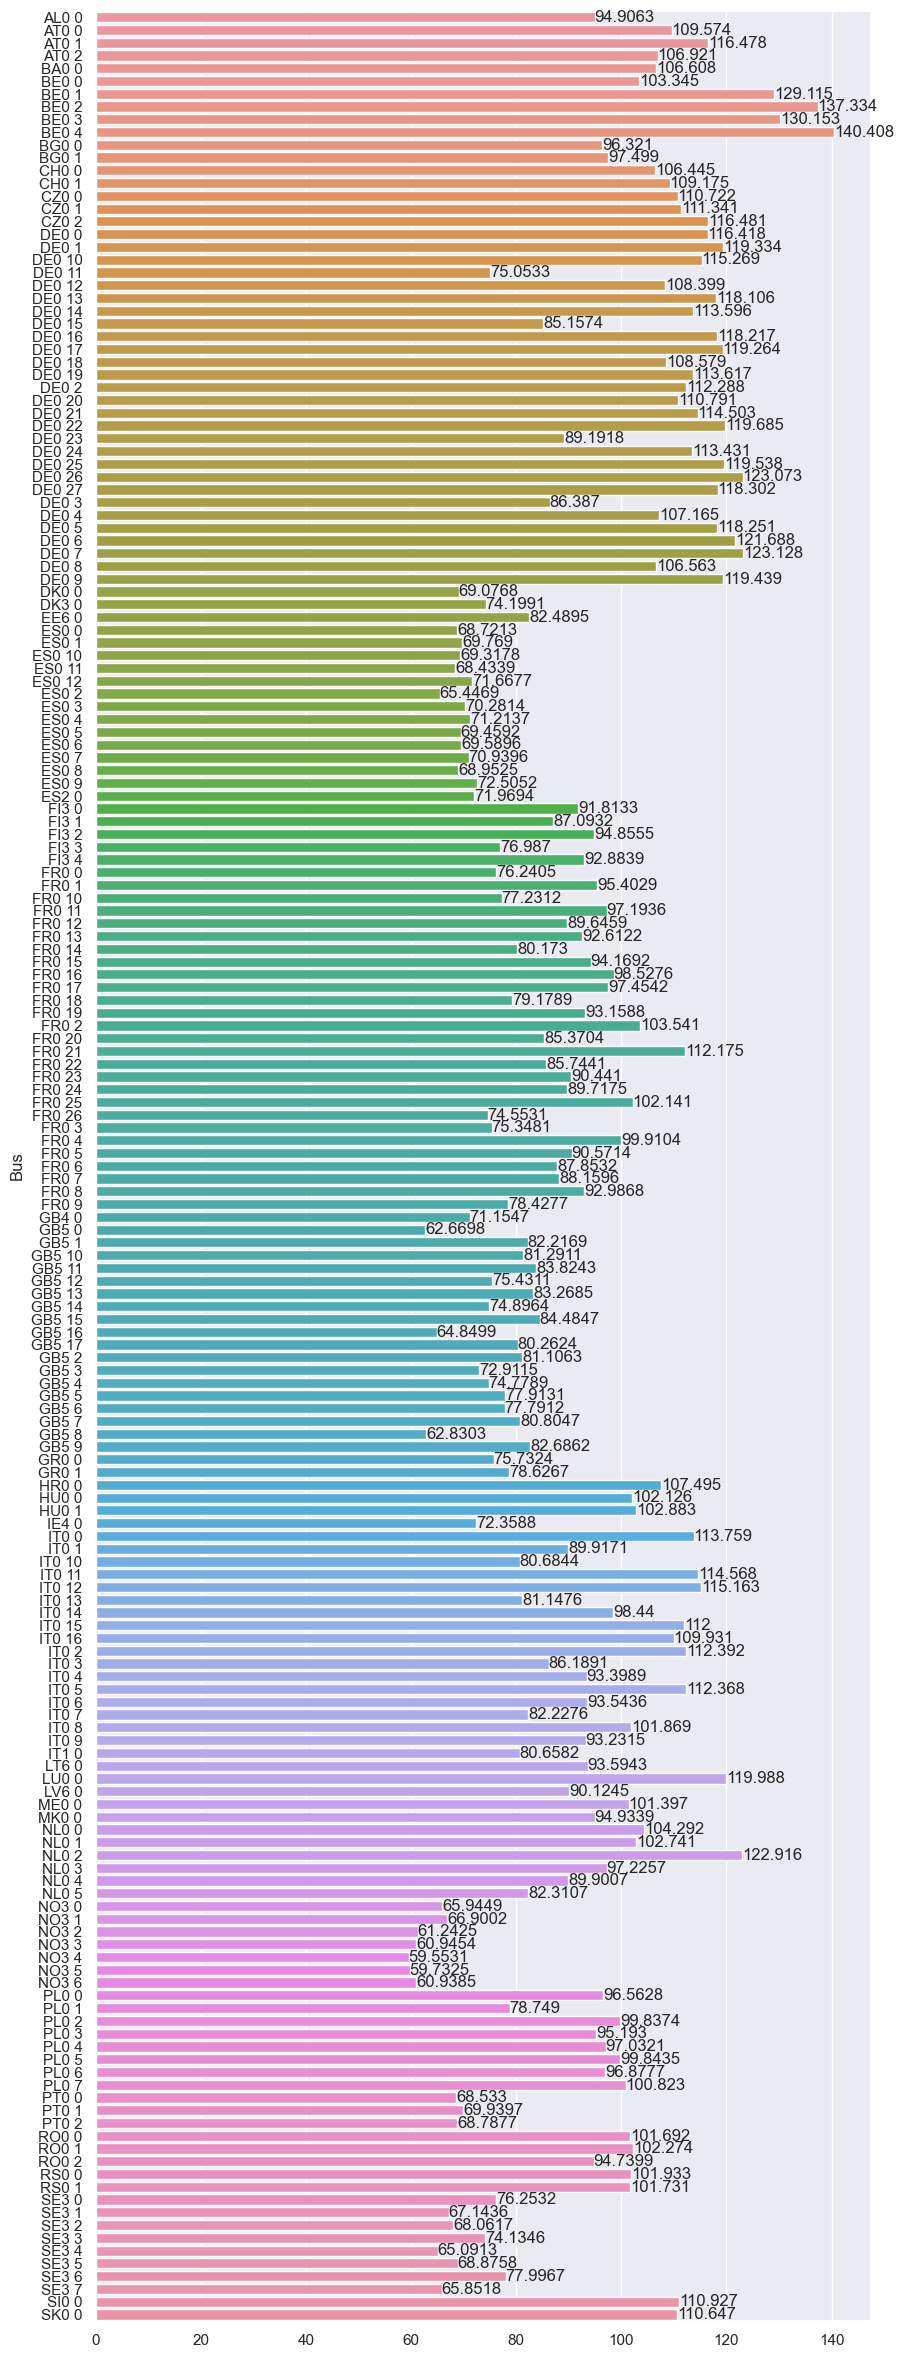

In [11]:
# Plot of all locational marginal prices per regions
lmp_regions = n.buses_t.marginal_price.loc[:, n.buses.location.unique()[:-1]]
df1 = lmp_regions.mean()
sns.set(rc={'figure.figsize':(10,30)})
ax = sns.barplot(y=df1.index, x=df1.values)

for i in ax.containers:
    ax.bar_label(i,)

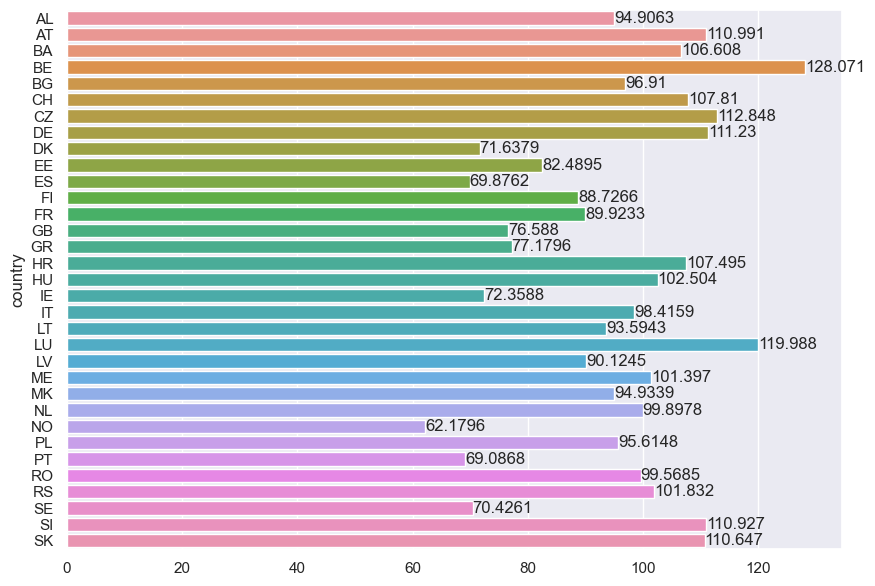

In [12]:
# Plot of lmp averaged over countries
df2 = lmp_regions.transpose()
df2["country"] = df2.index.str[:2]
df2 = df2.groupby(by="country").mean().mean(axis=1)
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.barplot(y=df2.index, x=df2.values)

for i in ax.containers:
    ax.bar_label(i,)

<AxesSubplot: xlabel='snapshot'>

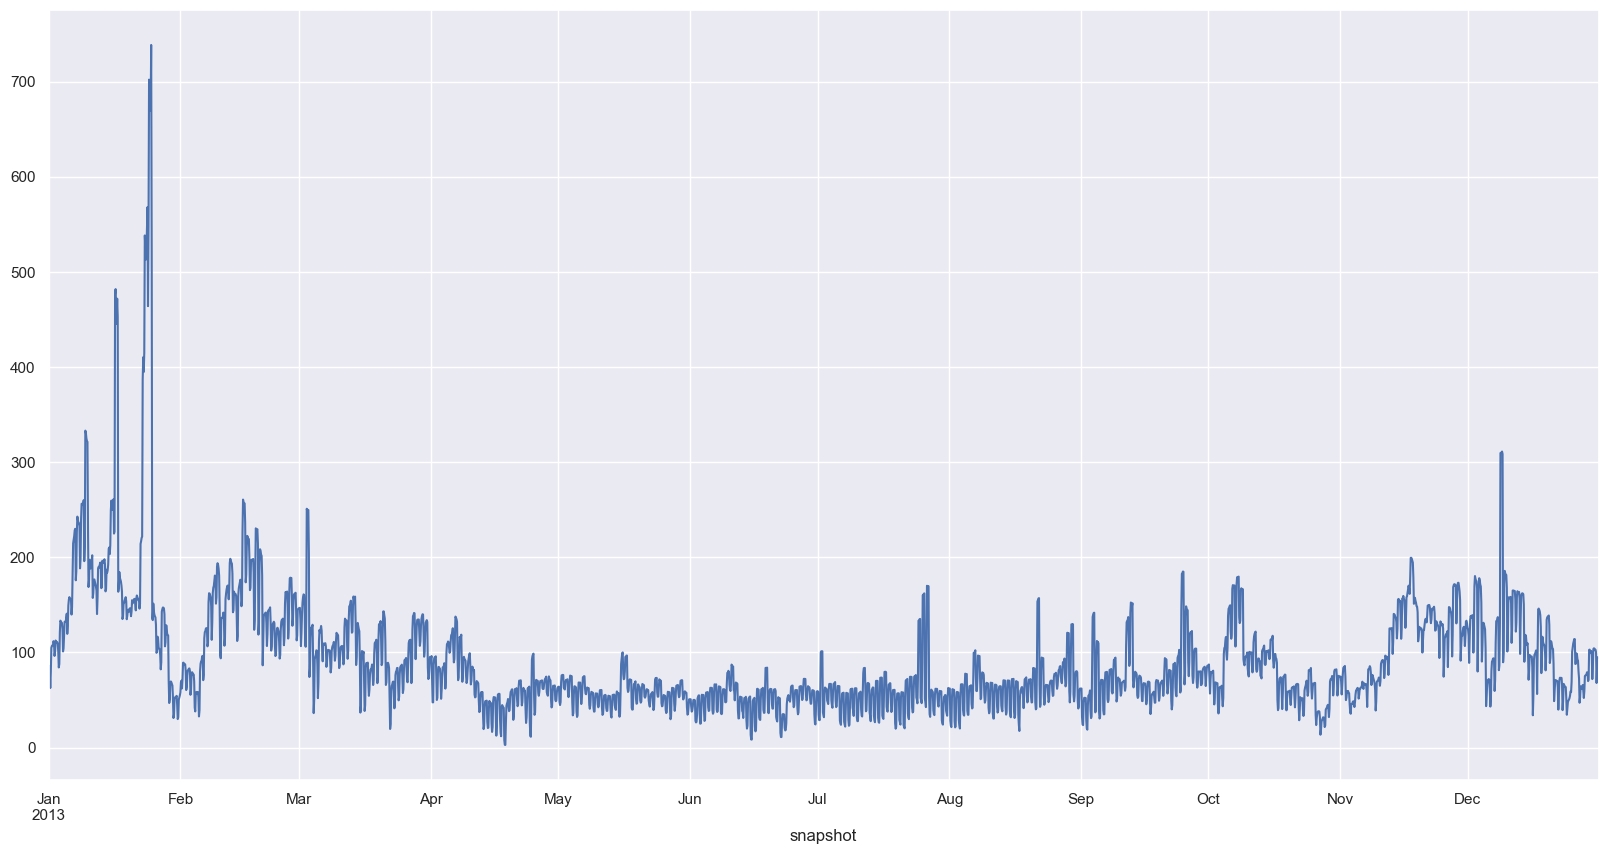

In [13]:
# Plot of average of lmp over 1 year
lmp_regions.mean(axis=1).plot(figsize=(20,10))

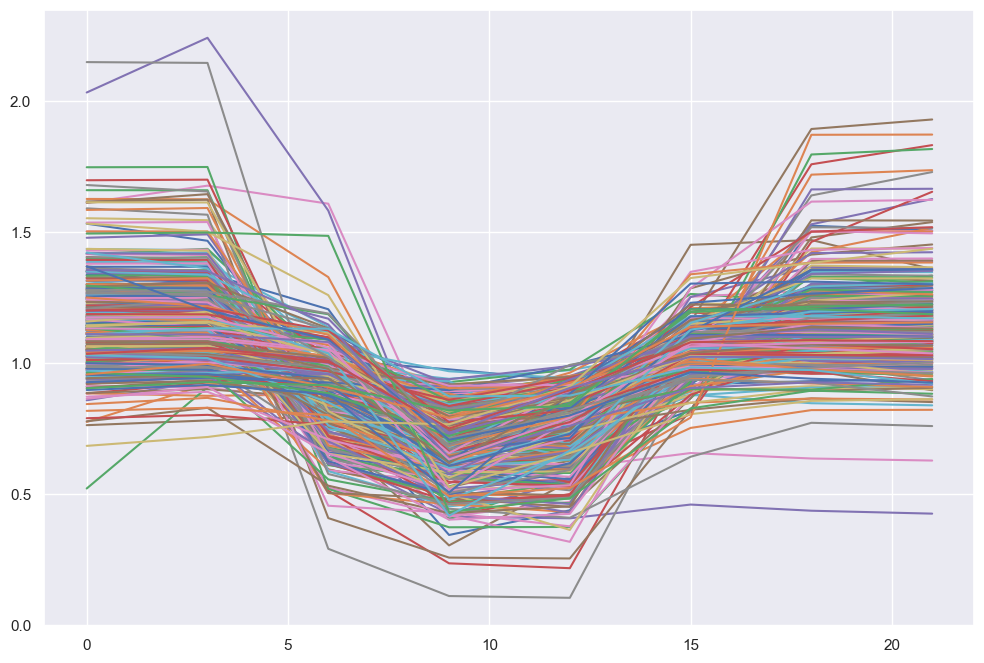

In [14]:
# Plot of lmp daily pattern of lmps normalized by the mean price of the day
plt.figure(figsize=(12, 8))

for day in days:
    df = lmp_regions[lmp_regions.index.date == day.date()].mean(axis=1)
    df_normalized = df / df.mean()
    plt.plot(df_normalized.index.hour, df_normalized.values)

<AxesSubplot: xlabel='hour_of_day', ylabel='market_value'>

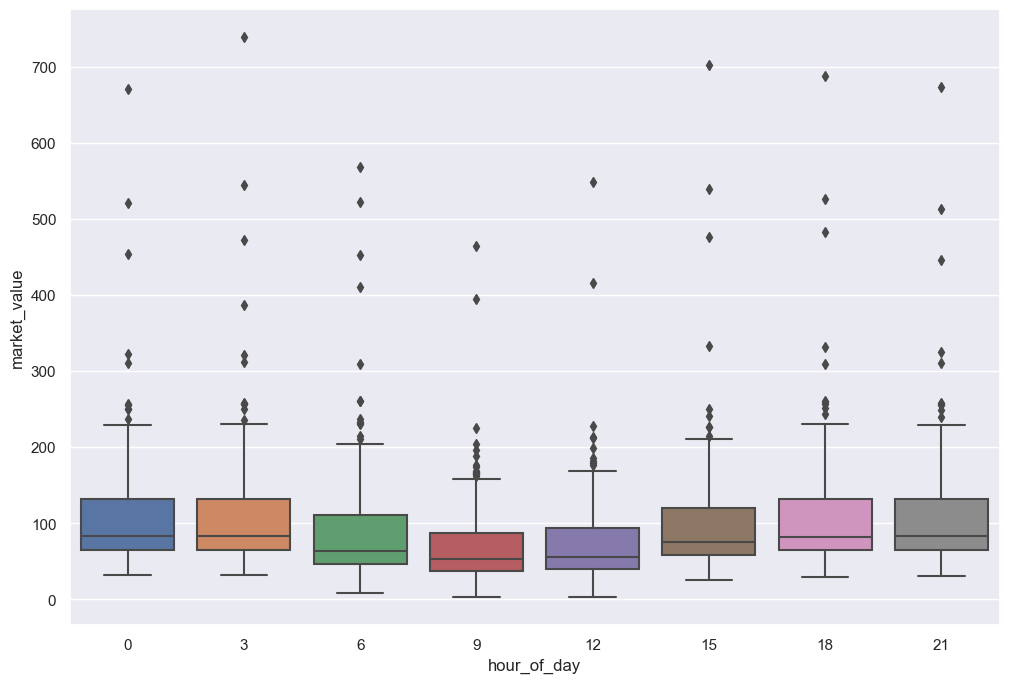

In [15]:
plt.figure(figsize=(12, 8))
df3 = pd.DataFrame(lmp_regions.mean(axis=1))
df3.columns = ["market_value"]
df3["hour_of_day"] = df3.index.hour
sns.boxplot(data=df3, y="market_value", x="hour_of_day")

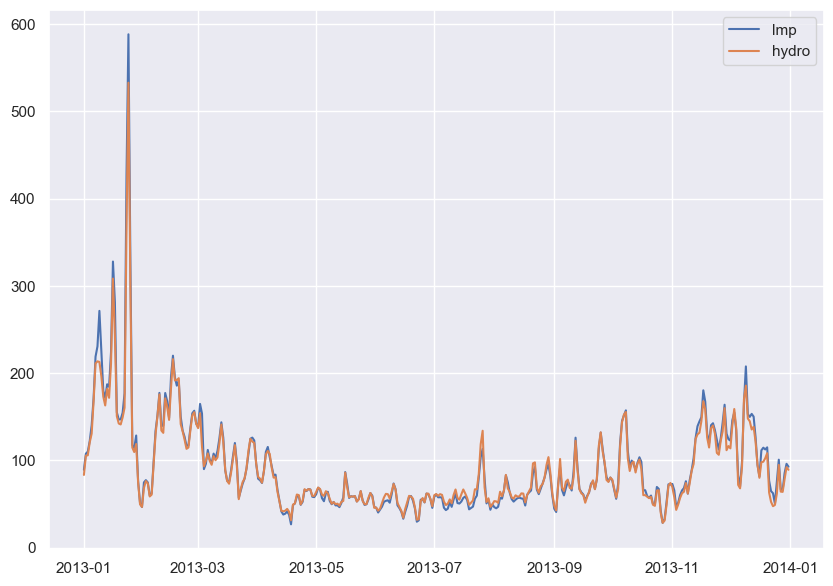

In [16]:
# Plot of daily average of lmp averaged over regions compared to any carrier mv
lmp_regions["indexer"] = lmp_regions.index.date
plt.plot(lmp_regions.groupby(by="indexer").mean().mean(axis=1), label="lmp")
plt.plot(market_values_by_time_index(n,days,"onwind").mean(axis=1), label="hydro")
plt.legend()

#### Regional distribution of market values per technology

In [24]:
# onshore wind
mv = market_values(n, "onwind")


In [25]:
n.buses

,v_nom,x,y,country,control,generator,carrier,location,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,,
AL0 0,380.0,19.894573,41.561804,AL,Slack,AL0 0 offwind-ac,AC,AL0 0,,None,1.0,0.0,inf,
AT0 0,380.0,15.759790,47.898676,AT,PQ,,AC,AT0 0,,None,1.0,0.0,inf,
AT0 1,380.0,10.293250,47.248827,AT,PQ,,AC,AT0 1,,None,1.0,0.0,inf,
AT0 2,380.0,13.580650,47.413095,AT,PQ,,AC,AT0 2,,None,1.0,0.0,inf,
BA0 0,380.0,18.122704,43.811367,BA,PQ,,AC,BA0 0,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 5,,None,1.0,0.0,inf,
SE3 6 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 6,,None,1.0,0.0,inf,
SE3 7 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 7,,None,1.0,0.0,inf,


#### Nodal Prices for every time step (sum)

In [122]:
carrier = "services rural heat"
df = pd.DataFrame(n.buses_t.marginal_price[n.buses[n.buses.carrier==carrier].index].sum(axis=1))

In [123]:
hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

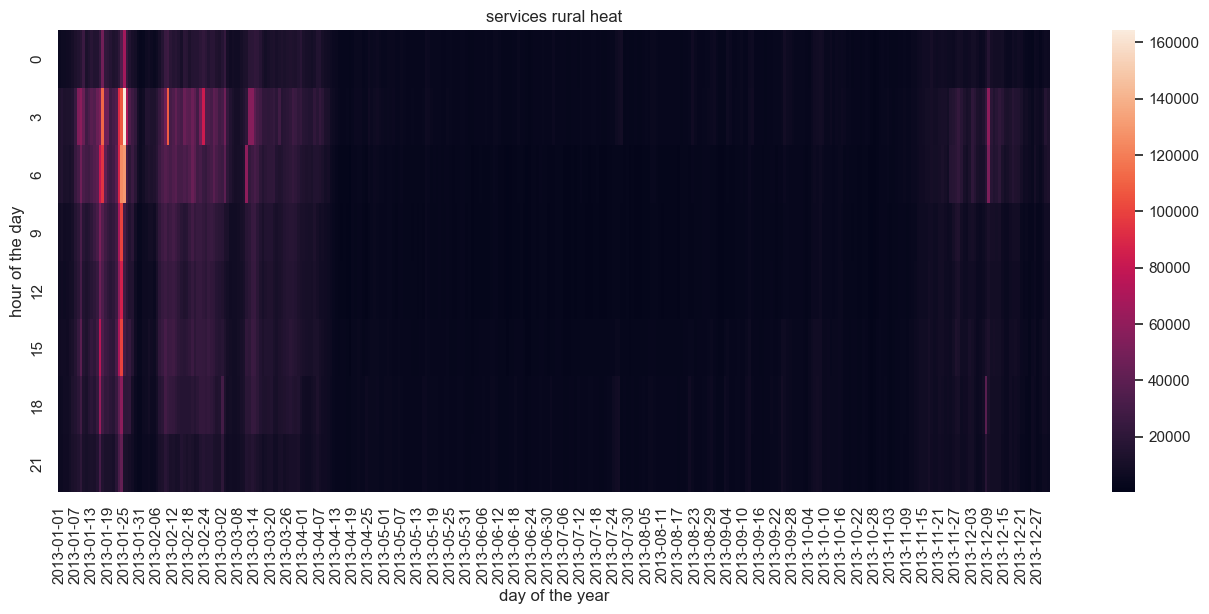

In [139]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(df_start.transpose(), linewidth=0.001)
plt.title(str(carrier))
plt.ylabel("hour of the day")
plt.xlabel("day of the year")
plt.show()

ToDoPlots
- ...